# How to determine the original resolution of an upscale image?

***

## Objective 
The objective of this notebook is to divulgate a general method of finding the original resolution of an upscale image or video. I will try to show you with images.


## The story
A friend told me that it was possible to determine the original resolution of an upscale image or video with the DCT (Discrete Cosine Transform), I then searched the web and found the following github project that did exactly that.
[GitHub - 0x09 – resdet - Detect source resolution of upscaled images](https://github.com/0x09/resdet)

In it is written **how it works:**

“
How? <br>
Traditional resampling methods tend to manifest as an odd extension of a signal's frequency domain combined with a low-pass filter (where the shape of the filter differs among the various resampling methods). Conveniently the Discrete Cosine Transform causes the zero-crossings of this extension to fall at exactly the offset the source was upscaled from  resdet works by trying to identify these inversions.
”

I found the explanation very simple but then when I read the source code I have found it really complex for such a simple description, but it is a full blown program that is made for fast execution and supporting images and videos.

So I started to implement a simple version just to play with the concept and come up with a different and simple implementation not in C but in Python and with a simpler detection method that I document here with pictures.

## The method used
My simple detection method is to just sum the absolute values of each row and each column and find the lower ones. My method like the method described in the above project 0x09/resdet, works best with uncompressed images that are then upscale.

## Requirements
* NumPy
* SciPy
* Pillow

## References
* [GitHub - 0x09 – resdet - Detect source resolution of upscaled images](https://github.com/0x09/resdet)
* [Docs of imageio](https://imageio.readthedocs.io/en/stable/examples.html)
* [Using the SciPy DCT function to create a 2D DCT-II](https://stackoverflow.com/questions/15978468/using-the-scipy-dct-function-to-create-a-2d-dct-ii)
* [Numpy Resize/Rescale Image](https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image)

## License
MIT Open Source

## Have fun!
Best regards, <br>
Joao Nuno Carvalho


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import imageio # pip install Pillow
import PIL
import sys
from scipy.fftpack import dct

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

## Read the Image with 512x512 resolution 3 color channels

(512, 512, 3)


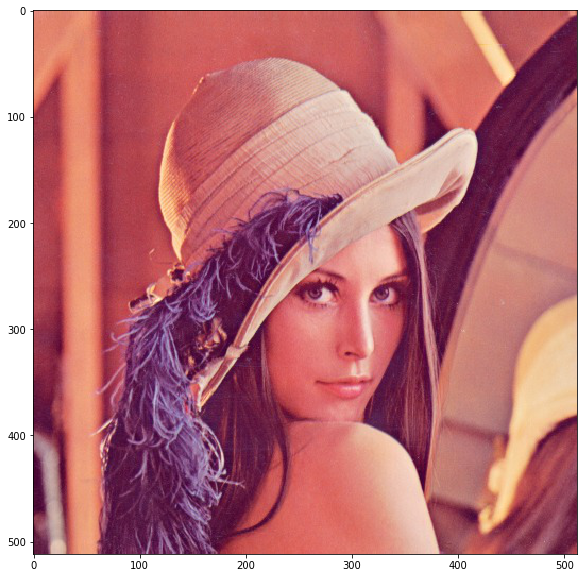

In [11]:
# Read the image from file.
im = imageio.imread("lena-color.jpg") # .astype(float)
print(im.shape)

f = plt.figure()
plt.imshow(im)

## Convert to grey scale

(512, 512)


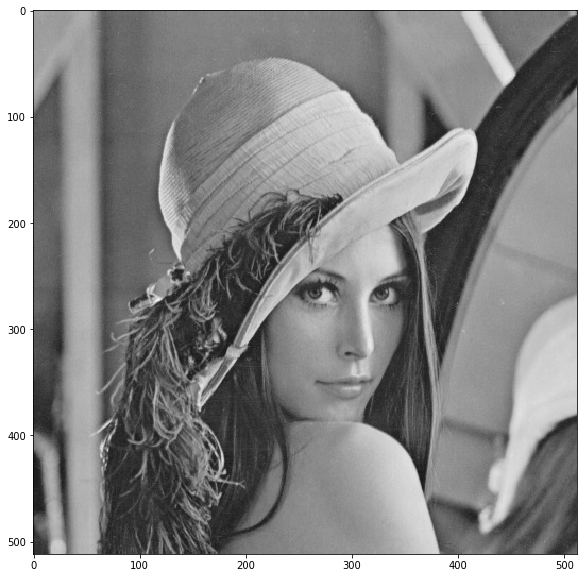

In [12]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Convert to grey scale.
gray_1 = rgb2gray(im) 
print(gray_1.shape)

plt.imshow(gray_1, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

## Create a resized copy ( upscale 768x768 ) of the gray scaled image using PIL

(768, 768)


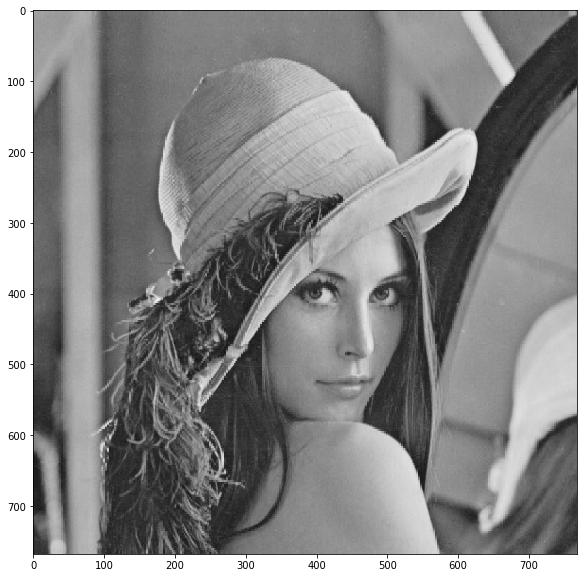

In [13]:
# Convert to a PIL image to use the resize interpolation of PIL lib.
im_2 = PIL.Image.fromarray(np.uint8(gray_1))
newsize = (768, 768) 
im_2 = im_2.resize(newsize)

# Convert the image back to NumPy array.
gray_2 = np.array(im_2).astype(float)
print(gray_2.shape)

plt.imshow(gray_2, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

## Apply the 2D DCT - Discrete Cosine Transform to the upscale image

[[ 9.48829115e+04 -7.76828631e+03 -1.76360255e+03 ... -9.75941396e+00
   9.97908325e+00 -6.78058304e-01]
 [ 5.33925500e+03  5.83983601e+03 -4.86535737e+03 ...  1.18497739e+01
   3.51752821e+00  1.54718873e+01]
 [-1.61833616e+02  2.34010499e+03 -4.52992312e+03 ...  1.34287066e+01
  -1.39127932e+01 -6.68698517e+00]
 ...
 [-1.48564194e+00 -9.19898052e-01 -1.35970158e-01 ... -2.69947699e+00
  -1.05292919e+00  1.08000939e+00]
 [ 3.18563040e+00  4.38182703e+00  1.74811373e+00 ...  1.93335189e+00
   2.00559672e-02 -2.21792654e+00]
 [-6.91952597e+00 -6.59513359e+00 -2.30356208e+00 ...  2.12200009e+00
   4.21001740e+00  3.40440572e-01]]


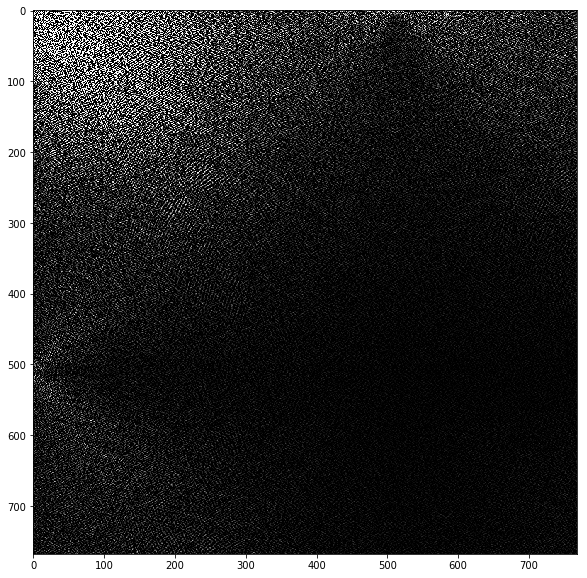

In [14]:
# 2D Discrete Cosine Transform DCT-II is applied, but SciPy lib only has
# a 1D DCT Transform. So we have to apply the equivalent of a dct of
# a transposed dct of the image. See the references for the explanaition.
t1 = dct(dct(gray_2, axis=0, norm='ortho'), axis=1, norm='ortho')

print(t1)

# This vmin and vmax values are very important so that you could see the
# effect that we will try to detect in the following parts of the code.
# It is what allows you to see clearly that the values of the DCT are
# different along the col == 512 and the row == 512. You can also see it
# has a rectangle that is tilted.  
plt.imshow(t1, cmap=plt.get_cmap('gray'), vmin=0, vmax=25)   # vmin=0, vmax=25

## Let’s try to search for patterns in the rows to start making a detection method

In [15]:
def totalLineAbsoluteSum(arLine):
    return np.sum(np.absolute(arLine)) 

def printArLine(arLine):
    print("\nshape: ", arLine.shape)
    for i in range(0, 30):
        print(str(arLine[i]), end='  ')
    print()
    print("totalSum: ", totalLineAbsoluteSum(arLine))
    print()

printArLine(t1[502])
printArLine(t1[512])
printArLine(t1[522])


shape:  (768,)
-1.597480848553693  -1.08301417734142  9.848729958535984  -2.7465951392007106  -11.879599692544652  11.125473472275884  -15.661554974743375  -0.3265025133689722  12.478568265290502  -1.267835956283038  -16.634749606795424  0.632004321178548  2.547303281493539  -6.579763223623084  9.124677467822341  -1.9264970412120104  -5.809493235147798  6.843261225958992  -8.476393614001365  3.9466224770902034  1.279876690648126  0.2011859677141739  -9.220138535443937  -19.445444244719297  4.774353328974082  0.1474160761571726  14.521965183402576  4.145004319563427  6.081803879506405  -3.567903941534937  
totalSum:  1289.1802546076156


shape:  (768,)
-8.625229591348408  -2.380939856728573  3.3497468500378833  -18.649639812080313  16.09014023233972  -1.5480258271661307  -20.20741816079457  3.2135466808169553  -3.3874119739713224  -7.085801313982474  7.133585405506657  -8.535118934648121  16.79529502382725  -1.2363528249283453  -4.625879985720989  3.122415489157834  1.5939788354027473 

## What have we found? 

Near row 512, the first numbers on the line (white points on the picture) have
an absolute value that is bigger than the ending values on the same line. That
means that for the majority of the black zone in the image, the absolute value of
the numbers of the result of 2D DCT are small, near zero.

**Knowing this**, we can find the XX and YY resolution that is pointed by this
result by summing the absolute of each row values or each col values and finding
the minimum total value.  The index of the minimum total value will be the original
resolution of the upscale image.  


## Let’s write the detector…

In [16]:
def calcMinTotal(dctTrans):
    maxRow, maxCol = dctTrans.shape   
    totalSumByRows = np.zeros(maxRow)
    minSum = (-1, sys.maxsize)  # (row_index, min_total_sum)
    for row in range(0, maxRow):
        totalSum = totalLineAbsoluteSum(dctTrans[row])
        totalSumByRows[row] = totalSum
        if totalSum < minSum[1]:
            minSum = (row, totalSum)
    return minSum


def calcRowAndColMinAbsoluteSum(dctTrans):
    minRowSum = calcMinTotal(dctTrans)
    dctTrans = dctTrans.transpose()
    minRowCol = calcMinTotal(dctTrans)
    return (minRowCol, minRowSum)


minRow, minCol = calcRowAndColMinAbsoluteSum(t1)
print("minSumRow: ", minRow, " Original YY resolution: ", minRow[0])
print("minSumCol: ", minCol, " Original XX resolution: ", minCol[0])

minSumRow:  (512, 1139.679636756139)  Original YY resolution:  512
minSumCol:  (512, 964.5162613103545)  Original XX resolution:  512


## Have fun!